# Titanic

### TL;DR

This exercise is the infamous Titanic dataset that all Kaggle newbs start out with. It is a classifcation problem where we are provided with some passenger information and we need predict whether they survive or not. Accuracy is used to evaluate predictions. At the time of submission, I was ranked 391/9642, top 4% on the leaderboard with an accuracy of 81.8%. By no means is this a perfect submission, nor did I write beautiful Python code; it is simply my scratch pad for attempting this problem set, so don't judge!

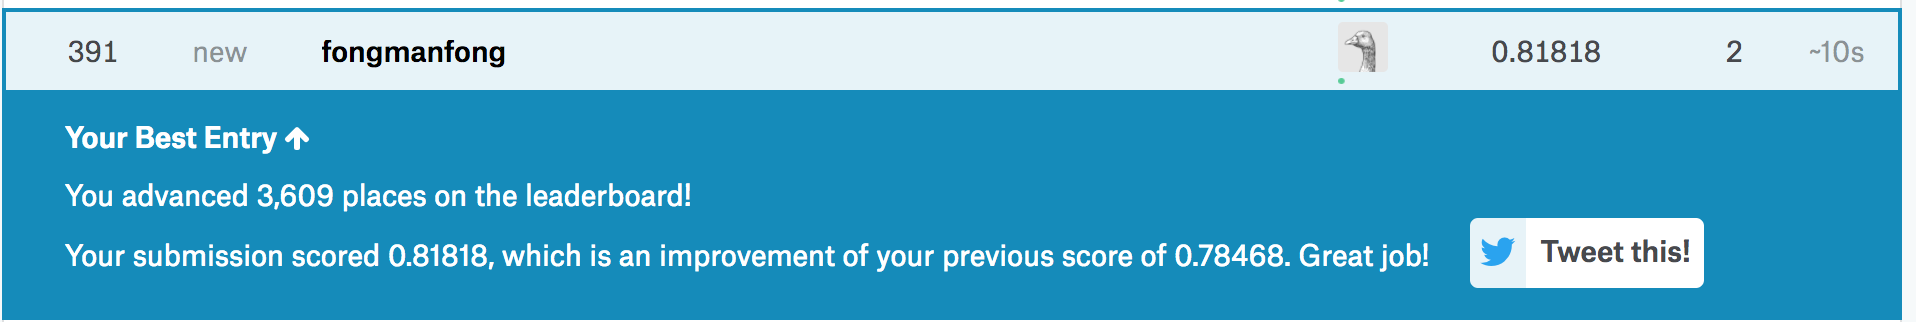

In [1]:
from IPython.display import Image
Image(filename='kaggle_titanic.png')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Let's take a look at the datasets that we're working with here. We're looking at around 2/3 split between training and test data set with 11 features and 1 target column. In both datasets, there are quite a missing values for Age and Cabin but the rest looks pretty complete.

Definition of each variable as per kaggle:
- PassengerID
- Survived
- Pclass
- Name
- Sex
- Age
- SibSp
- Parch
- Ticket
- Fare
- Cabin
- Embarked

In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
print train.shape
print test.shape

(891, 12)
(418, 11)


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [9]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Rosenbaum, Miss. Edith Louise",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [10]:
print "total records in train & test: %s" % (str(train.shape[0] + test.shape[0])) 

total records in train & test: 1309


In [11]:
print "Train: Total Survived %s" % str(train['Survived'].sum())
print "Train: Total People %s " % str(train.shape[0])

Train: Total Survived 342
Train: Total People 891 


## Feature Exploration / Cleaning / Engineering

Here we'll go through one feature at a time exploring it, cleaning it if necessary and do feature engineering if it make sense.

### Sex

First off, we see from above Sex is a categorical variable so I'll define a simple function map it to numerical values. It would be interesting to just see if there is a correlation between gender and survival. We see females has a significantly higher chance of survival.

In [12]:
def map_sex(df, col):
    return df[col].map(lambda x: 1 if x == 'female' else 0)

In [13]:
train['Sex'] = map_sex(train, 'Sex')
test['Sex'] = map_sex(test, 'Sex')

In [14]:
train.groupby('Sex')['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
Sex,,,
0,109,577,0.188908
1,233,314,0.742038


### Embarked

We noticed that Embarked has one missing value in the training set. Since its a categorical, it would intuitively make sense that we can use the probability of the missing value being S, C, Q. We noticed that there is the highest chance of the missing value being S. Segmenting this by Survived, we see people Embarked = C is slightly correlated with survival rate vs S & Q

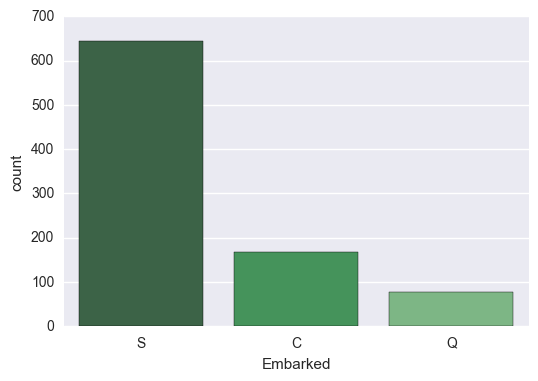

In [15]:
sns.countplot(x="Embarked", data=train, palette="Greens_d");

In [16]:
train['Embarked'].fillna('S', inplace=True)
test['Embarked'].fillna('S', inplace=True)

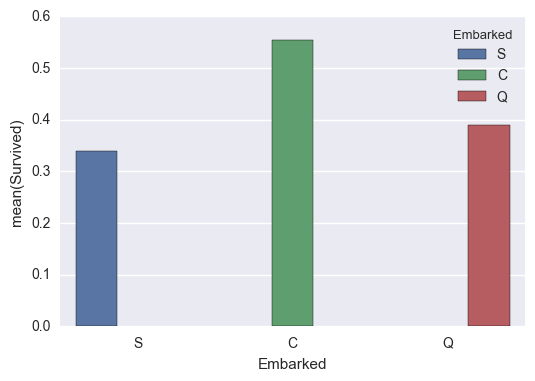

In [17]:
sns.barplot(x="Embarked", y="Survived", hue="Embarked", data=train, ci=None);

### Name

Name is a little more interesting. At face value, there are many different names but we see they all have a title. We know Mr. is different than Mrs. and we also see some interesting titles like Master. and Lady., not your typical titles. Doing some research on Google we can see how these titles are used. We also noticed that there are alot of titles that mean similar things, or identifying personel with a different social class. We can group these titles together into intuitive categories to see if we see anything interesting with survival rate.

In [18]:
def extract_title(df, col):
    return df[col].str.extractall('([A-Z]+[a-z]+\.)').unstack()[0]

In [19]:
train['Title'] = extract_title(train, 'Name')
test['Title'] = extract_title(test, 'Name')

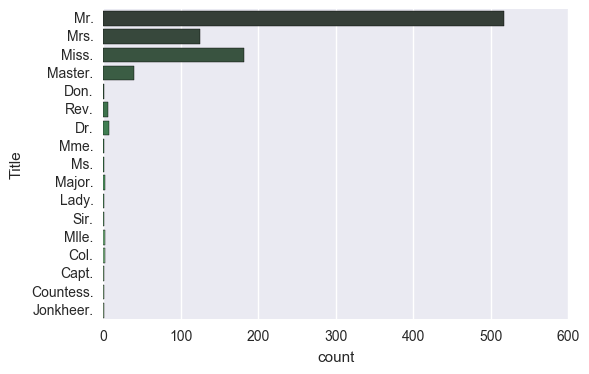

In [20]:
sns.countplot(y="Title", data=train, palette="Greens_d");

In [21]:
test['Title'].value_counts()

Mr.        240
Miss.       78
Mrs.        72
Master.     21
Col.         2
Rev.         2
Dona.        1
Dr.          1
Ms.          1
Name: Title, dtype: int64

One thing to notice here is that Dona. is in test data but not the training set. We should include that in our categorization. Based on intuitive grouping, I've essentially classified all titles that are used for people with certain social class as Noble and anything else as Other.

Similar insights as gender, we see female titles Mrs. and Miss have strong correlation with survival. People with noble title tend to have higher chance of surviving, which intuitively make sense. The so called "important" people tend to get favored treatments.

In [22]:
title_map = {
    'Mme.': 'Mr.',
    'Mlle.': 'Miss.',
    'Ms.': 'Miss.',
    'Sir.' : 'Noble',
    'Rev.' : 'Other',
    'Major.': 'Other',
    'Lady.': 'Noble',
    'Jonkheer.': 'Noble',
    'Dr.': 'Other',
    'Countess.' : 'Noble',
    'Col.': 'Other',
    'Capt.': 'Other',
    'Don.': 'Noble', 
    'Dona.': 'Noble',
    'Master.': 'Noble',
    'Mr.': 'Mr.',
    'Mrs.': 'Mrs.',
    'Miss.': 'Miss.'
}

In [23]:
def map_title(df, col):
    return df[col].map(lambda x: title_map[x] if x in title_map.keys() else 'Other')

In [24]:
train['Title'] = map_title(train, 'Title')
test['Title'] = map_title(test, 'Title')

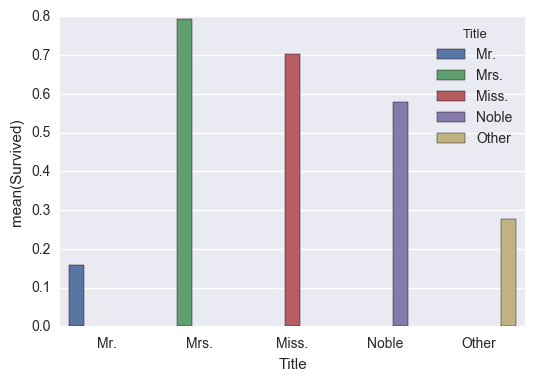

In [25]:
sns.barplot(x="Title", y="Survived", hue="Title", data=train, ci=None);

### SibSp & Parch

These two variables give us information about the passengers family, (spouse, siblings, parents, children). The tricky part is we don't really know if someone has a sibling or a spouse, similarly a parent or a child. We can probably take some time to infer, which may give us better insight into whether that person is a mother with certain number of child. This could be a good signal since we know mothers and children tend to be saved first in situations like Titanic. Given that blurb, in this exercise, I've kept it basic. 

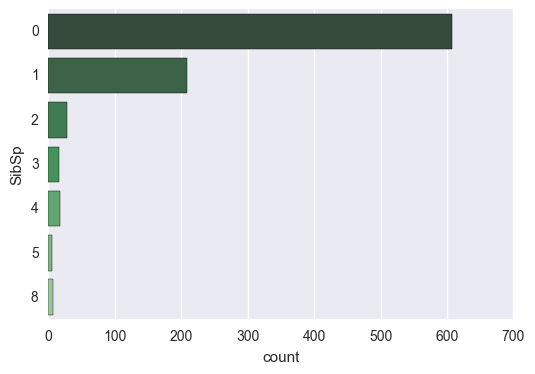

In [26]:
sns.countplot(y="SibSp", data=train, palette="Greens_d");

In [27]:
train.groupby('SibSp')['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
SibSp,,,
0,210,608,0.345395
1,112,209,0.535885
2,13,28,0.464286
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


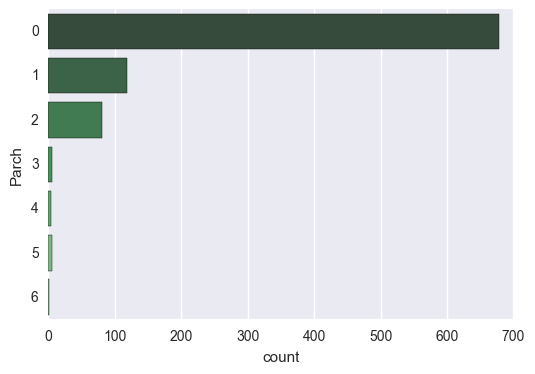

In [28]:
sns.countplot(y="Parch", data=train, palette="Greens_d");

In [29]:
train.groupby('Parch')['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
Parch,,,
0,233,678,0.343658
1,65,118,0.550847
2,40,80,0.500000
3,3,5,0.600000
4,0,4,0.000000
5,1,5,0.200000
6,0,1,0.000000


We see pasengers with one sibling or spouse have a slight correlation with survival. Similarly for passengers with 1 parent or child. One thing we can also look at is what both of these variables together tell us. Together will identify the family size of the passenger. We see more interesting results if we look at family. People with family size of 3 is highly correlated with surviving, while people with family size of 1 and 2 have a slight correlation with survival.

In [30]:
train['Family Size'] = train['SibSp'] + train['Parch']
test['Family Size'] = train['SibSp'] + train['Parch']

In [31]:
train.groupby('Family Size')['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
Family Size,,,
0,163,537,0.303538
1,89,161,0.552795
2,59,102,0.578431
3,21,29,0.724138
4,3,15,0.200000
5,3,22,0.136364
6,4,12,0.333333
7,0,6,0.000000
10,0,7,0.000000


### Cabin

As seen above, we noticed that there are a lot of missing data points for cabin. Although I just replace this information with unknown, I can probably do a better job of inferring what cabin person could be in. For example inferring which passengers belong to the same family and use knowledge that family prefer to stay close to each other. Maybe we can use name and see which members have the same last name, look at SibSP, Parch and Family size, are they in the same Pclass.

For cabin, I'm only interested in the first letter of the cabin. Reason being, the letter usually denotes the section of the cabin which implies different areas of the boat. Intuitively, even in the Titanic movie, people in different areas of the boat had different survival rate.

In [32]:
train['Cabin'].fillna('Unknown', inplace=True)
test['Cabin'].fillna('Unknown', inplace=True)

In [33]:
def parse_cabin (df, col):
    return df[col].map(lambda x: re.sub(r'[0-9]+', '', x)[0])

train['Cabin - Parsed'] = parse_cabin(train, 'Cabin')
test['Cabin - Parsed'] = parse_cabin(test, 'Cabin')

In [34]:
train.groupby('Cabin - Parsed')['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
Cabin - Parsed,,,
A,7,15,0.466667
B,35,47,0.744681
C,35,59,0.593220
D,25,33,0.757576
E,24,32,0.750000
F,8,13,0.615385
G,2,4,0.500000
T,0,1,0.000000
U,206,687,0.299854


In [35]:
test['Cabin - Parsed'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin - Parsed, dtype: int64

One thing to notice here is that the test set does not have cabin T. As a result, any cabin room letters that are not in the test set I will set as U (for Unknown). The only case here is T

In [36]:
train['Cabin - Parsed'] = train['Cabin - Parsed'].map(lambda x: x if x in test['Cabin - Parsed'].value_counts().index.tolist() else 'U')

### Ticket

The approach that I've taken here is to look at the ticket label. Similar intuition as cabin, ticket label usually identify a certain type of ticket for certain types of passenger. Looking at the ticket values below, we see that there are a lot of clean up work to be done, like cleaning up empty spaces. I've made a simple assumption here that the periods are just noise. One hypothesis is that tickets were hand written back then so there could of been more variation to how tickets were labelled, like some people wrote A and some wrote just A (period). Tickets with no identifier I've given it a no identifier label. Ticket labels with a / I've considered it to have two labels and introduced a label count variable.

In [37]:
train['Ticket'].head(30).unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216'], dtype=object)

In [38]:
def ticket_split(x):
    x_split = x.split(' ')
    if len(x_split) > 1:
        return re.sub('\.', '', x_split[0]).lower()
    else:
        return 'No Identifier'

In [39]:
def ticket_first_label(x):
    return x.split('/')[0]

In [40]:
def ticket_label_count(x):
    if x == 'No Identifier':
        return 0
    else:
        return len(x.split('/'))

In [41]:
train['Ticket - Parsed'] = train['Ticket'].map(lambda x: ticket_split(x))
train['Ticket - First Label'] = train['Ticket - Parsed'].map(lambda x: ticket_first_label(x))
train['Ticket Label Count'] = train['Ticket - Parsed'].map(lambda x: ticket_label_count(x))

In [42]:
train['Ticket - First Label'].value_counts()

No Identifier    665
pc                60
ca                42
a                 26
ston              18
soton             17
sc                16
w                 10
c                  5
fcc                5
soc                5
so                 4
pp                 3
a5                 2
we                 2
sw                 2
p                  2
a4                 1
fa                 1
sp                 1
fc                 1
sco                1
sop                1
wep                1
Name: Ticket - First Label, dtype: int64

We see a lot of ticket labels that appears very infrequently in our dataset and can be treated like outliers/noise. A I've grouped all the ticket labels that appear less than ~3% of training set into the Other category to produce a ticket label that has more representative sample size. A lot of levels in a categorical variable can throw off prediction accuracy. We see some interesting correlation between ticket label PC and surviving.

In [43]:
train['Ticket - First Label'] = train['Ticket - First Label'].map(lambda x: x if x in ['No Identifier', 'pc', 'ca', 'a'] else 'Other' )

In [44]:
test['Ticket - Parsed'] = train['Ticket'].map(lambda x: ticket_split(x))
test['Ticket - First Label'] = test['Ticket - Parsed'].map(lambda x: ticket_first_label(x))
test['Ticket Label Count'] = test['Ticket - Parsed'].map(lambda x: ticket_label_count(x))
test['Ticket - First Label'] = test['Ticket - First Label'].map(lambda x: x if x in ['No Identifier', 'pc', 'ca', 'a'] else 'Other' )

In [45]:
train.groupby(('Ticket - First Label'))['Survived'].aggregate((np.sum, len, np.mean))

,sum,len,mean
Ticket - First Label,,,
No Identifier,255,665,0.383459
Other,32,98,0.326531
a,2,26,0.076923
ca,14,42,0.333333
pc,39,60,0.650000


### Age

Age is probably the most interesting attribute here. We have around 150 missing records and we need to do something with them. One simple way of handling this is to simple populate it with a sample statistic like mean or median. This would lose a lot of information (~1/8 of the training set would be labeled with median / average age). Instead we can consider segmenting our data set to see if we can find more meaning ways of inferring age. 

First, lets take a look if age has anything to do with survival rate. We saw that gender had a huge impact on survival, lets segment by Sex to see if female vs. male age distribution.

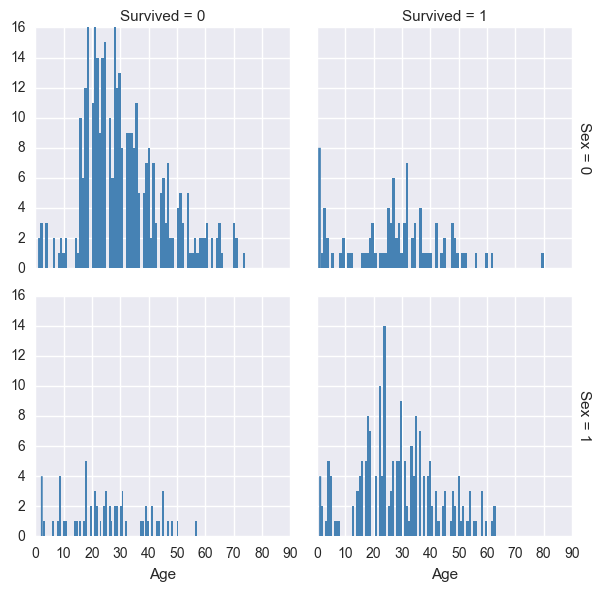

In [46]:
h = sns.FacetGrid(train, row='Sex', col="Survived", margin_titles=True)
h.map(plt.hist, "Age", color="steelblue", bins=85, lw=0)

Results are fairly intuitive, young to middle age male has the lowest chance of survival, while young to middle age women has the highest chance. This is one layer or segmenting. Other variables I am considering is Title and Family size. Title make sense because a title like Miss vs Mrs sometimes can give u some indication of the age range of an individual. Family size also make sense because certain age groups tend to travel certain way. E.g possibly people travelling individual tend to fall into a younger a group while people with a family of tend to fall into higher age group. 

Because family size is a continious variable, It would be easier to segment our data by labelling and converting it into a categorical variable. I've defined three labels:

- Individuals (Family size = 0)
- Small Family (Family size between 1 and 3)
- Big Family (Family size above 3)

Like we expected, we see very different results based on our segmentation, which we would of missed if we simply replaced the missing values with a blanket sample statistic. A teenage girl travelling with family we would call her Miss and simultaneously a young professional female that's not married travelling individually we would also call her Miss. 

In [47]:
def define_indiv (df, col):
    return df[col].map(lambda x: 1 if x == 0 else 0)

train['Individual'] = define_indiv(train, 'Family Size')
test['Individual'] = define_indiv(test, 'Family Size')

In [48]:
def small_family (df, col):
    return df[col].map(lambda x: 1 if x > 0 and x <=3 else 0)

train['Small Family'] = small_family(train, 'Family Size')
test['Small Family'] = small_family(test, 'Family Size')

In [49]:
def big_family (df, col):
    return df[col].map(lambda x: 1 if x >=4 else 0)

train['Big Family'] = big_family(train, 'Family Size')
test['Big Family'] = big_family(test, 'Family Size')

In [50]:
segment_age = train.groupby(['Sex', 'Title', 'Individual', 'Big Family', 'Small Family'])['Age'].aggregate((np.mean, np.median, len))
segment_age

mean  median    len
Sex Title Individual Big Family Small Family                          
0   Mr.   0          0          1             32.681818    31.0  109.0
                     1          0             27.750000    17.5   11.0
          1          0          0             32.388316    29.0  397.0
    Noble 0          0          1              6.174762     3.0   23.0
                     1          0              5.250000     4.0   18.0
          1          0          0             39.000000    39.0    2.0
    Other 0          0          1             49.200000    50.0    5.0
          1          0          0             45.363636    51.0   12.0
1   Miss. 0          0          1             15.901961    15.0   59.0
                     1          0             12.000000     9.0   23.0
          1          0          0             27.654321    26.0  103.0
    Mr.   1          0          0             24.000000    24.0    1.0
    Mrs.  0          0          1             34.243902    33.0   95.0
                     1          0             40.000000    40.0   10.0
          1          0          0             41.812500    41.0   20.0
    Noble 0          0          1             48.000000    48.0    1.0
          1          0          0             33.000000    33.0    1.0
    Other 1          0          0             49.000000    49.0    1.0

Based on the segmentation, I take the median age in each group and build a lookup dictionary. Then I simply go through missing data in the training data and test data and fill in with the inferred age.

In [51]:
age_median_map = segment_age['median'].to_dict()
age_median_map

{(0, 'Mr.', 0, 0, 1): 31.0,
 (0, 'Mr.', 0, 1, 0): 17.5,
 (0, 'Mr.', 1, 0, 0): 29.0,
 (0, 'Noble', 0, 0, 1): 3.0,
 (0, 'Noble', 0, 1, 0): 4.0,
 (0, 'Noble', 1, 0, 0): 39.0,
 (0, 'Other', 0, 0, 1): 50.0,
 (0, 'Other', 1, 0, 0): 51.0,
 (1, 'Miss.', 0, 0, 1): 15.0,
 (1, 'Miss.', 0, 1, 0): 9.0,
 (1, 'Miss.', 1, 0, 0): 26.0,
 (1, 'Mr.', 1, 0, 0): 24.0,
 (1, 'Mrs.', 0, 0, 1): 33.0,
 (1, 'Mrs.', 0, 1, 0): 40.0,
 (1, 'Mrs.', 1, 0, 0): 41.0,
 (1, 'Noble', 0, 0, 1): 48.0,
 (1, 'Noble', 1, 0, 0): 33.0,
 (1, 'Other', 1, 0, 0): 49.0}

In [52]:
def compile_age_segment_key (df, col1, col2, col3, col4, col5):
    return list(zip(df[col1], df[col2], df[col3]))

In [53]:
train['grouped_sex_title_ind'] = compile_age_segment_key(train, 'Sex', 'Title', 'Individual', 'Big Family', 'Small Family')
test['grouped_sex_title_ind'] = compile_age_segment_key(test, 'Sex', 'Title', 'Individual', 'Big Family', 'Small Family')

In [54]:
train['Age'] = train['Age'].fillna(-1)
test['Age'] = test['Age'].fillna(-1)

In [55]:
def age_map(df, age_col, lookup_col):
    if df[age_col] == -1:
        if df[lookup_col] in age_median_map.keys():
            return age_median_map[df[lookup_col]]
        else:
            return 28
    else:
        return df[age_col]

In [56]:
train['Age'] = train.apply(lambda x: age_map(x, 'Age', 'grouped_sex_title_ind'), axis=1)
test['Age'] = test.apply(lambda x: age_map(x, 'Age', 'grouped_sex_title_ind'), axis=1)

### Fare

Fare only has one missing value in the training set so we can simply fill it with a sample statistic. I chose median here because average fare price can be thrown off by couple VIP super expensive tickets.

In [57]:
print train['Fare'].mean()
print train['Fare'].median()

32.2042079686
14.4542


In [58]:
train['Fare'].fillna(train['Fare'].median(), inplace=True)
test['Fare'].fillna(train['Fare'].median(), inplace=True)

## Modelling and Making Prediction

Alright now that we have cleaned up our features, let just take a quick peak at how our data set looks like now. We have a lot of extra columns when we were doing feature engineering and we won't be using everything. Let's only look at what we want to use.

In [59]:
feature = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', \
                      'Fare', 'Embarked', 'Title', 'Family Size', 'Individual', \
                      'Cabin - Parsed', 'Ticket - First Label', 'Ticket Label Count',\
                      'Small Family', 'Big Family']
target = ['Survived']

In [60]:
train_cleaned = train[feature + target]

In [61]:
train_cleaned

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family Size,Individual,Cabin - Parsed,Ticket - First Label,Ticket Label Count,Small Family,Big Family,Survived
0,1,3,0,22.0,1,0,7.2500,S,Mr.,1,0,U,a,2,1,0,0
1,2,1,1,38.0,1,0,71.2833,C,Mrs.,1,0,C,pc,1,1,0,1
2,3,3,1,26.0,0,0,7.9250,S,Miss.,0,1,U,Other,2,0,0,1
3,4,1,1,35.0,1,0,53.1000,S,Mrs.,1,0,C,No Identifier,0,1,0,1
4,5,3,0,35.0,0,0,8.0500,S,Mr.,0,1,U,No Identifier,0,0,0,0
5,6,3,0,28.0,0,0,8.4583,Q,Mr.,0,1,U,No Identifier,0,0,0,0
6,7,1,0,54.0,0,0,51.8625,S,Mr.,0,1,E,No Identifier,0,0,0,0
7,8,3,0,2.0,3,1,21.0750,S,Noble,4,0,U,No Identifier,0,0,1,0
8,9,3,1,27.0,0,2,11.1333,S,Mrs.,2,0,U,No Identifier,0,1,0,1
9,10,2,1,14.0,1,0,30.0708,C,Mrs.,1,0,U,No Identifier,0,1,0,1


In [62]:
test_cleaned = test[feature]

Because sklearn models doesn't like categorical variables, we need to turn the categorical variables into individual binary vectors.

In [63]:
encode = ['Embarked', 'Title', 'Cabin - Parsed', 'Ticket - First Label', 'Pclass']
train_cleaned = pd.get_dummies(train_cleaned, columns=encode)
test_cleaned = pd.get_dummies(test_cleaned, columns=encode)

In [64]:
all_name = train_cleaned.columns
feature_name = all_name.drop(['Survived'])
target_name = 'Survived'

In [65]:
X_train = train_cleaned[feature_name]
y_train = train_cleaned[target_name]

I've decided to go with tree based based classified for several, but not perfect, reasons. Firstly because tree classifiers provide out-of-the-box tool to identify feature importance based on information gain in the algorithm. This is handy as we can fine tune the model by eliminating not important features that could overfit our model. Secondly I specifically chose RandomForest for its robustness. This is not to say my reasonings are perfect, I should definitely take the time to explore additional models and benchmark against each other to compare overall predictability.

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [67]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [68]:
feature_importance = pd.DataFrame()
feature_importance['Feature'] = X_train.columns
feature_importance['Importance'] = clf.feature_importances_

In [69]:
feature_importance.sort('Importance', ascending=False)

/Users/jasonfong/.pyenv/virtualenvs/starscream/2.7.11/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Feature,Importance
0,PassengerId,0.144271
5,Fare,0.138941
2,Age,0.127578
15,Title_Mr.,0.109264
1,Sex,0.100539
14,Title_Miss.,0.039642
34,Pclass_3,0.035005
16,Title_Mrs.,0.033395
6,Family Size,0.032260
26,Cabin - Parsed_U,0.026881


The first classifier is to understand the feature importance based on information gain. Using this information, I remove variables that has less than median importance between all features. Using the remaining features, I retrain the Random Forest Classifier. Using the GridSearch approach provided by sklearn, I do a 10 fold stratified cross validation with different model parameters to see which one gives back the highest accuracy score. This is requires a lot of computational resource so I've kept the number of parameters to tune to a limit number.

In [70]:
model = SelectFromModel(clf, prefit=True, threshold='median')
X_train_pruned = model.transform(X_train)

In [71]:
X_train_pruned.shape

(891, 18)

In [72]:
test_cleaned = test_cleaned[X_train.columns]

In [73]:
X_test = model.transform(test_cleaned)

In [74]:
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [75]:
forest = RandomForestClassifier(max_features='auto')

parameters = {
    'n_estimators': [200, 400],
    'max_depth': [7,8,9],
    'max_features': ['auto', 'sqrt', 0.2, 0.1, 0.3]
}

grid_search = GridSearchCV(forest, param_grid = parameters, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

grid_search.fit(X_train_pruned, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400], 'max_features': ['auto', 'sqrt', 0.2, 0.1, 0.3], 'max_depth': [7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [76]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.551260,0.102523,0.824916,0.898991,7,auto,200,"{u'max_features': u'auto', u'n_estimators': 20...",21,0.811111,...,0.764045,0.896509,0.865169,0.894015,0.818182,0.899128,0.018430,0.005235,0.035680,0.007386
1,1.083204,0.211322,0.824916,0.897869,7,auto,400,"{u'max_features': u'auto', u'n_estimators': 40...",21,0.811111,...,0.764045,0.897756,0.842697,0.887781,0.818182,0.897883,0.046973,0.005760,0.033113,0.006513
2,0.534582,0.103314,0.831650,0.896372,7,sqrt,200,"{u'max_features': u'sqrt', u'n_estimators': 20...",3,0.822222,...,0.775281,0.897756,0.876404,0.891521,0.818182,0.897883,0.027647,0.004900,0.034244,0.004275
3,1.081219,0.210273,0.828283,0.896871,7,sqrt,400,"{u'max_features': u'sqrt', u'n_estimators': 40...",10,0.811111,...,0.775281,0.897756,0.842697,0.889027,0.829545,0.896638,0.042517,0.014242,0.030173,0.005299
4,0.559877,0.106487,0.827160,0.891759,7,0.2,200,"{u'max_features': 0.2, u'n_estimators': 200, u...",17,0.822222,...,0.764045,0.885287,0.842697,0.885287,0.818182,0.891656,0.036081,0.005945,0.037502,0.005569
5,1.098315,0.207690,0.824916,0.892756,7,0.2,400,"{u'max_features': 0.2, u'n_estimators': 400, u...",21,0.822222,...,0.764045,0.882793,0.842697,0.890274,0.818182,0.895392,0.061478,0.009542,0.032468,0.006434
6,0.519593,0.102361,0.822671,0.885399,7,0.1,200,"{u'max_features': 0.1, u'n_estimators': 200, u...",28,0.800000,...,0.752809,0.885287,0.853933,0.879052,0.840909,0.882939,0.028259,0.006771,0.036066,0.006851
7,1.028223,0.207865,0.820426,0.885522,7,0.1,400,"{u'max_features': 0.1, u'n_estimators': 400, u...",30,0.811111,...,0.764045,0.884040,0.808989,0.880299,0.840909,0.890411,0.050448,0.013109,0.030899,0.003937
8,0.556100,0.102440,0.828283,0.903606,7,0.3,200,"{u'max_features': 0.3, u'n_estimators': 200, u...",10,0.822222,...,0.752809,0.901496,0.865169,0.897756,0.818182,0.901619,0.021271,0.005419,0.039733,0.006573
9,1.109477,0.209158,0.823793,0.903730,7,0.3,400,"{u'max_features': 0.3, u'n_estimators': 400, u...",27,0.811111,...,0.764045,0.905237,0.865169,0.900249,0.818182,0.900374,0.033352,0.014129,0.034555,0.005352


In [77]:
grid_search.best_score_

0.83613916947250277

In [78]:
grid_search.best_params_

{'max_depth': 9, 'max_features': 0.2, 'n_estimators': 200}

In [79]:
test['Survived'] = pd.Series(grid_search.predict(X_test))

In [80]:
test[['PassengerId', 'Survived']].to_csv('titanic_prediction.csv')